In [3]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(2048)
environ['n_epochs']= '500'
environ['batch_norm']= 'True'
environ['loss_func']='MSE'
environ['layers'] = '700 600 350 200 180'
environ['dropouts'] = '0.2 '*5
environ['log'] = 'True'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:1'
environ['dataset'] = 'data/speedup_dataset2.pkl'

%run utils.ipynb

In [4]:
train_dl, val_dl, test_dl = train_dev_split(dataset, batch_size, num_workers, log=log)

db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

In [5]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)
    
if loss_func == 'MSE':
    criterion = nn.MSELoss()
else:
    criterion = mape_criterion

l = fai.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion],
               callback_fns=[partial(EarlyStoppingCallback, mode='min', 
                                     monitor='rmse_criterion', min_delta=0, patience=10)])

if optimizer == 'SGD':
    l.opt_func = optim.SGD

In [6]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [49]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


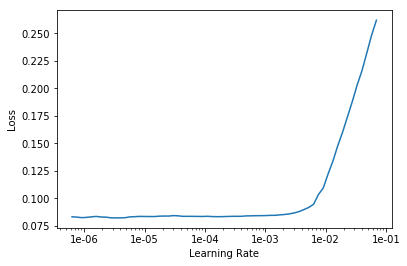

In [50]:
l.recorder.plot()

In [86]:
lr = 4e-04

In [87]:
l.fit_one_cycle(300, lr)

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,1.218288,1.038103,28.771376,1.018848
2,1.201501,1.039758,33.201405,1.019621
3,1.172035,1.036012,35.344971,1.017752
4,1.144021,1.037630,39.036961,1.018605
5,1.126360,1.036403,39.982014,1.017861
6,1.117400,1.019743,35.960964,1.009782
7,1.093922,0.987179,30.990385,0.993544
8,1.057602,0.938932,23.258991,0.968954
9,1.010880,0.874046,15.586488,0.934851
10,0.964765,0.806389,13.090454,0.897981


Epoch 138: early stopping


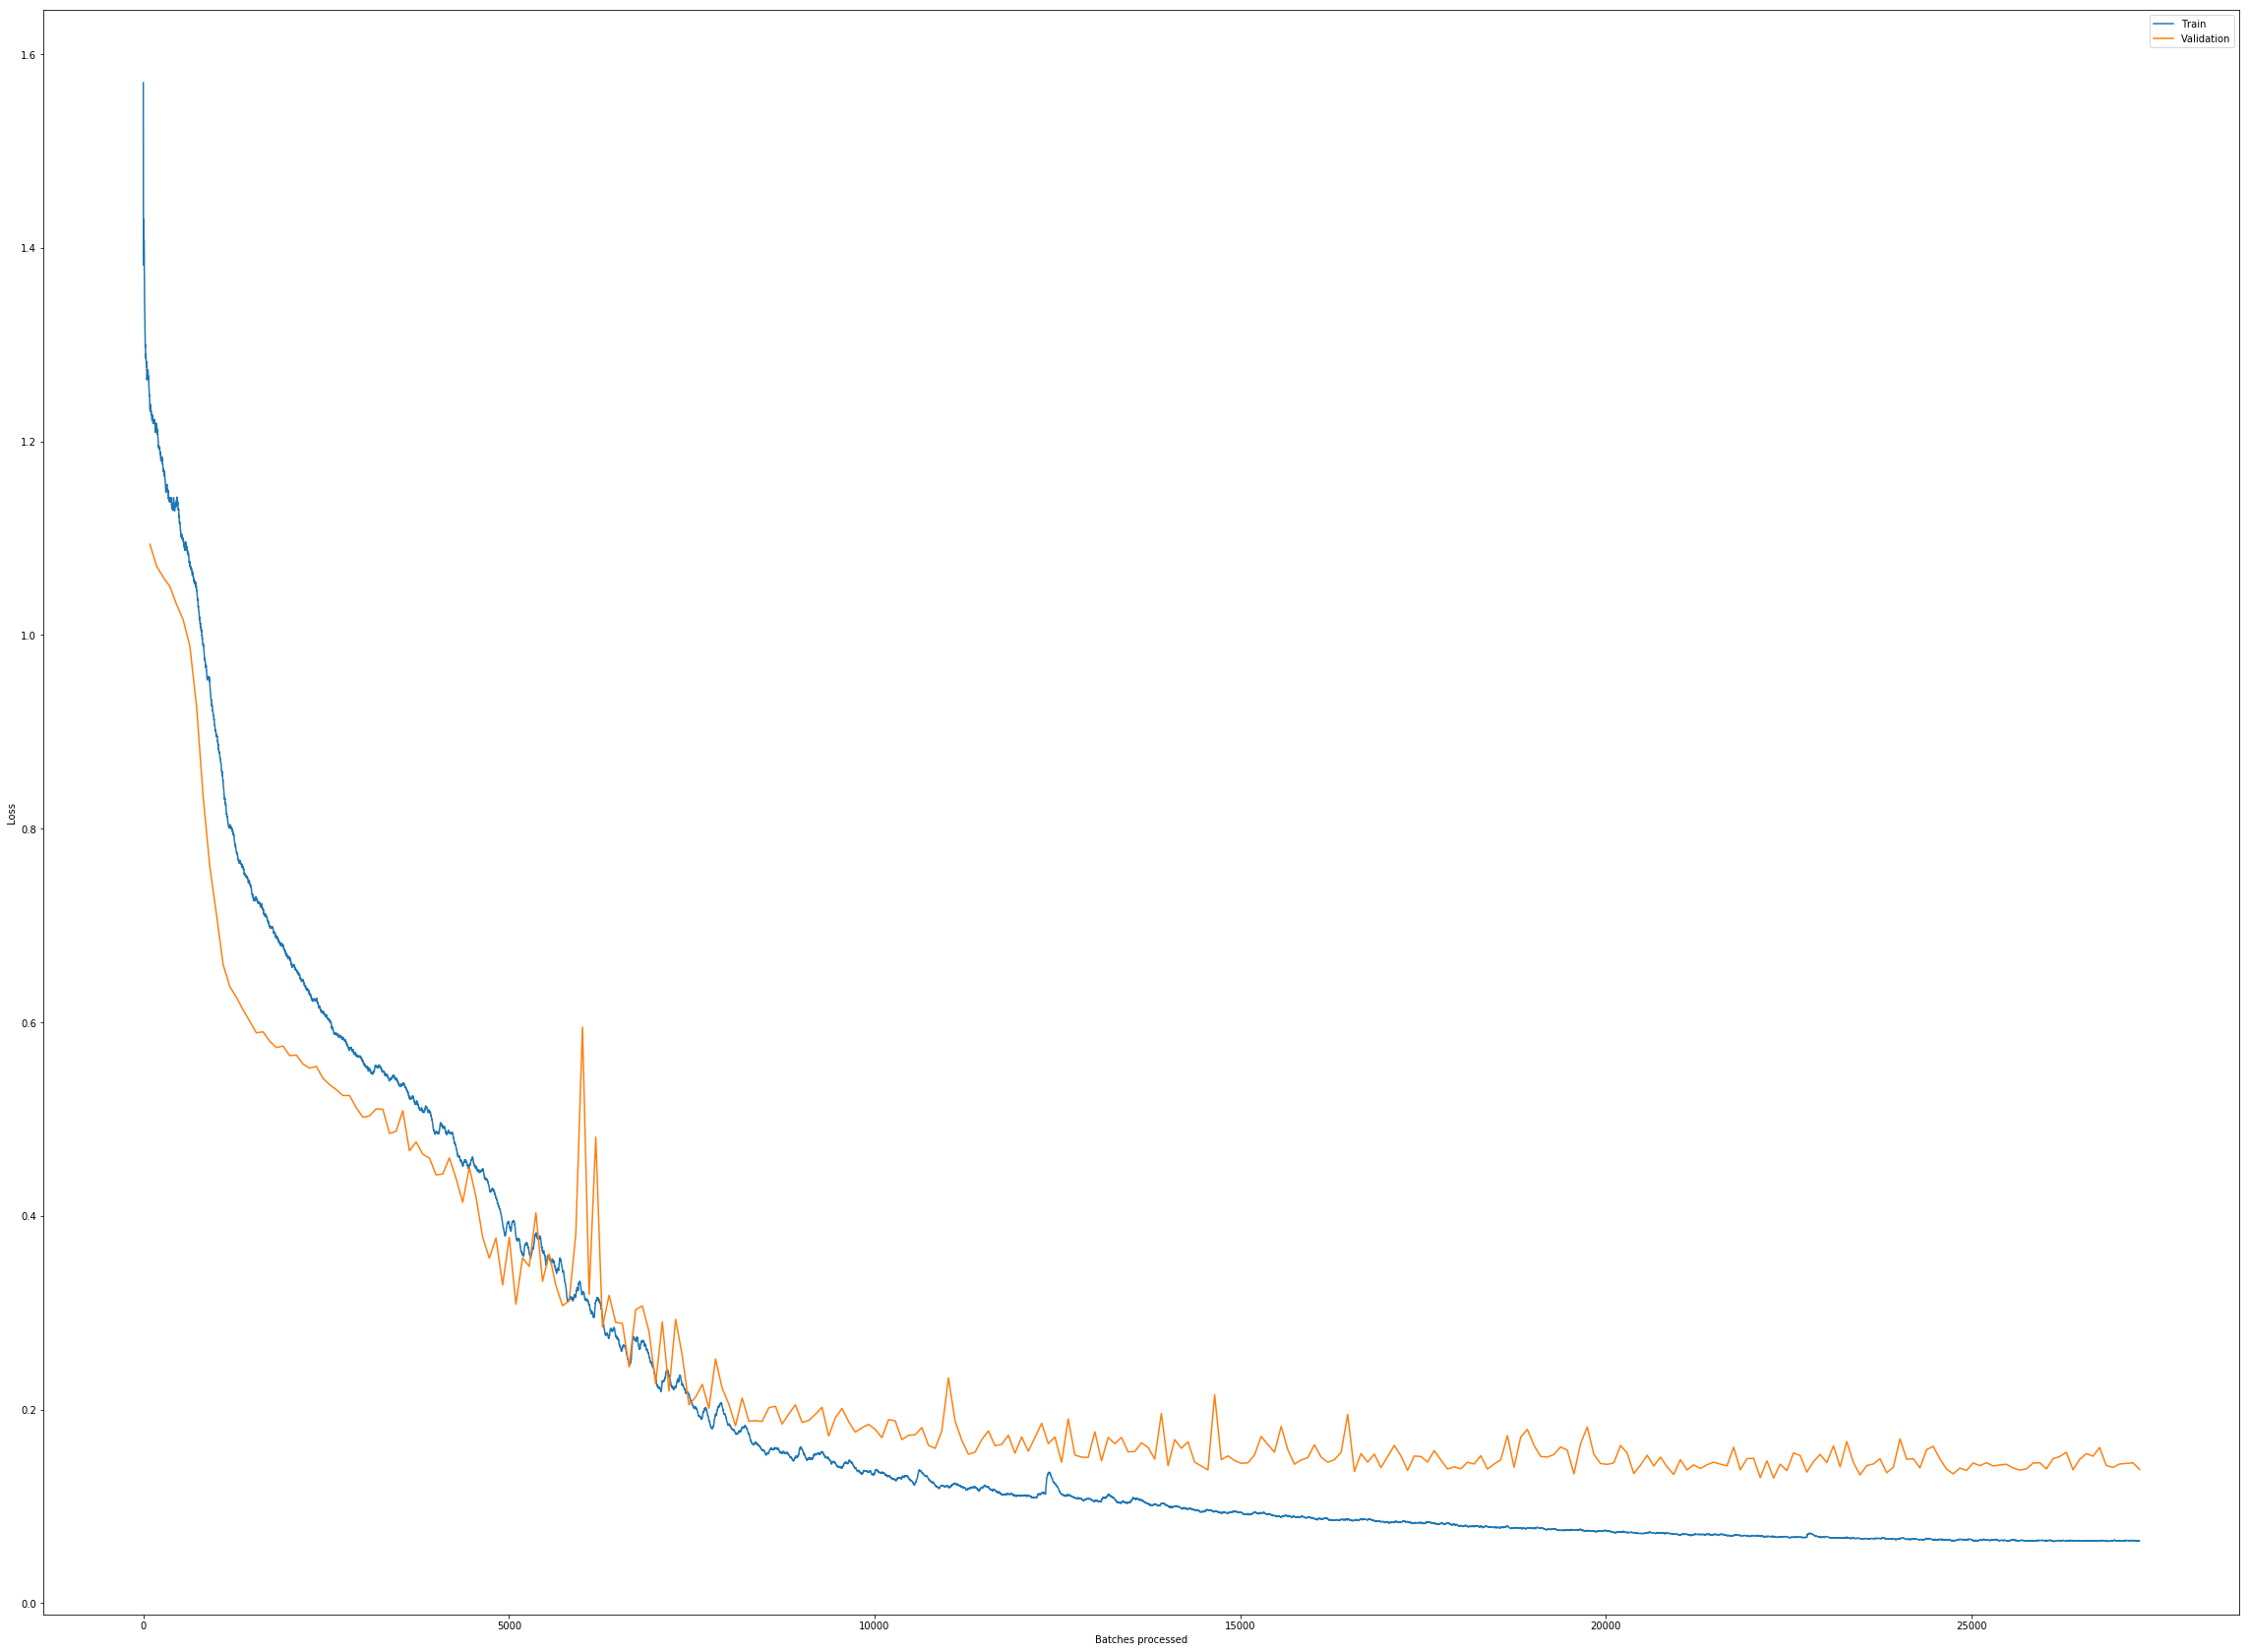

In [65]:
l.recorder.plot_losses()

In [81]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [7]:
val_df = get_results_df(val_dl, l.model, log=log)
train_df = get_results_df(train_dl, l.model, log=log)

In [31]:
df = train_df

In [18]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.741191,1.601825,0.526940,43.607189
std,1.805397,1.653595,0.752682,65.229561
min,0.013184,0.010685,0.000021,0.001503
25%,0.342246,0.301894,0.043898,8.130150
50%,1.022471,0.970127,0.178467,21.112929
75%,2.201316,2.176448,0.735866,54.667862
max,7.587024,7.522551,5.670684,567.068420


In [16]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.444771,1.827336,0.618629,36.454636
std,1.481798,1.896899,0.884432,53.734081
min,0.016828,0.014435,0.000100,0.021209
25%,0.362628,0.400166,0.063978,11.121379
50%,0.914559,1.103367,0.247398,24.897342
75%,1.767421,2.574541,0.807857,52.510747
max,7.594975,11.454972,9.794488,1176.047852


In [23]:
df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,657.000000,657.000000,657.000000,657.000000
mean,3.948848,5.115778,1.365126,29.287535
std,1.486039,2.790569,1.714994,38.937504
min,0.398863,0.105179,0.003013,0.206864
25%,2.479949,2.706949,0.270402,8.261179
50%,4.648192,5.420588,0.649103,21.397005
75%,4.834735,6.326712,1.784681,33.637047
max,5.690990,12.500638,7.442226,280.300598


In [39]:
df[(df.tile + df.unroll + df.interchange > 0) & (df.target < 1.2) & (df.prediction > 2.2)]

,prediction,target,abs_diff,APE,interchange,tile,unroll
8012,4.518717,0.876359,3.642358,415.623901,0,0,1
8222,3.971404,0.892633,3.078771,344.908997,1,0,0
8223,4.290122,0.860874,3.429248,398.345154,1,0,1
8225,4.312116,0.872250,3.439865,394.366791,1,0,1
8226,4.335424,0.949050,3.386374,356.817322,1,0,1
8511,4.573765,0.915355,3.658410,399.671051,0,0,1
8622,4.655011,0.909092,3.745920,412.050873,0,0,1
9209,3.971276,0.675678,3.295598,487.746918,1,0,0
9210,4.362455,0.759095,3.603361,474.691925,1,0,1
9212,4.378021,0.815398,3.562624,436.918549,1,0,1


In [48]:
train_dl.dataset.schedules[131184].name

'function185_schedule_108'

/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


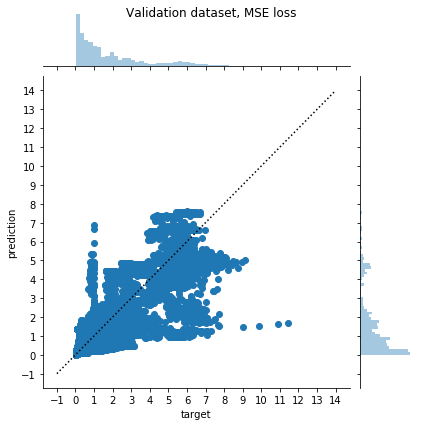

In [30]:
df1 = df[(df.tile + df.unroll + df.interchange > 0) & (df.target < 1.2) & (df.prediction > 2.2)]
#joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = df
joint_plot(t, f"Validation dataset, {loss_func} loss")


In [27]:
df_ = df.sort_values(by=["target"])

df_['x'] = range(len(df_))

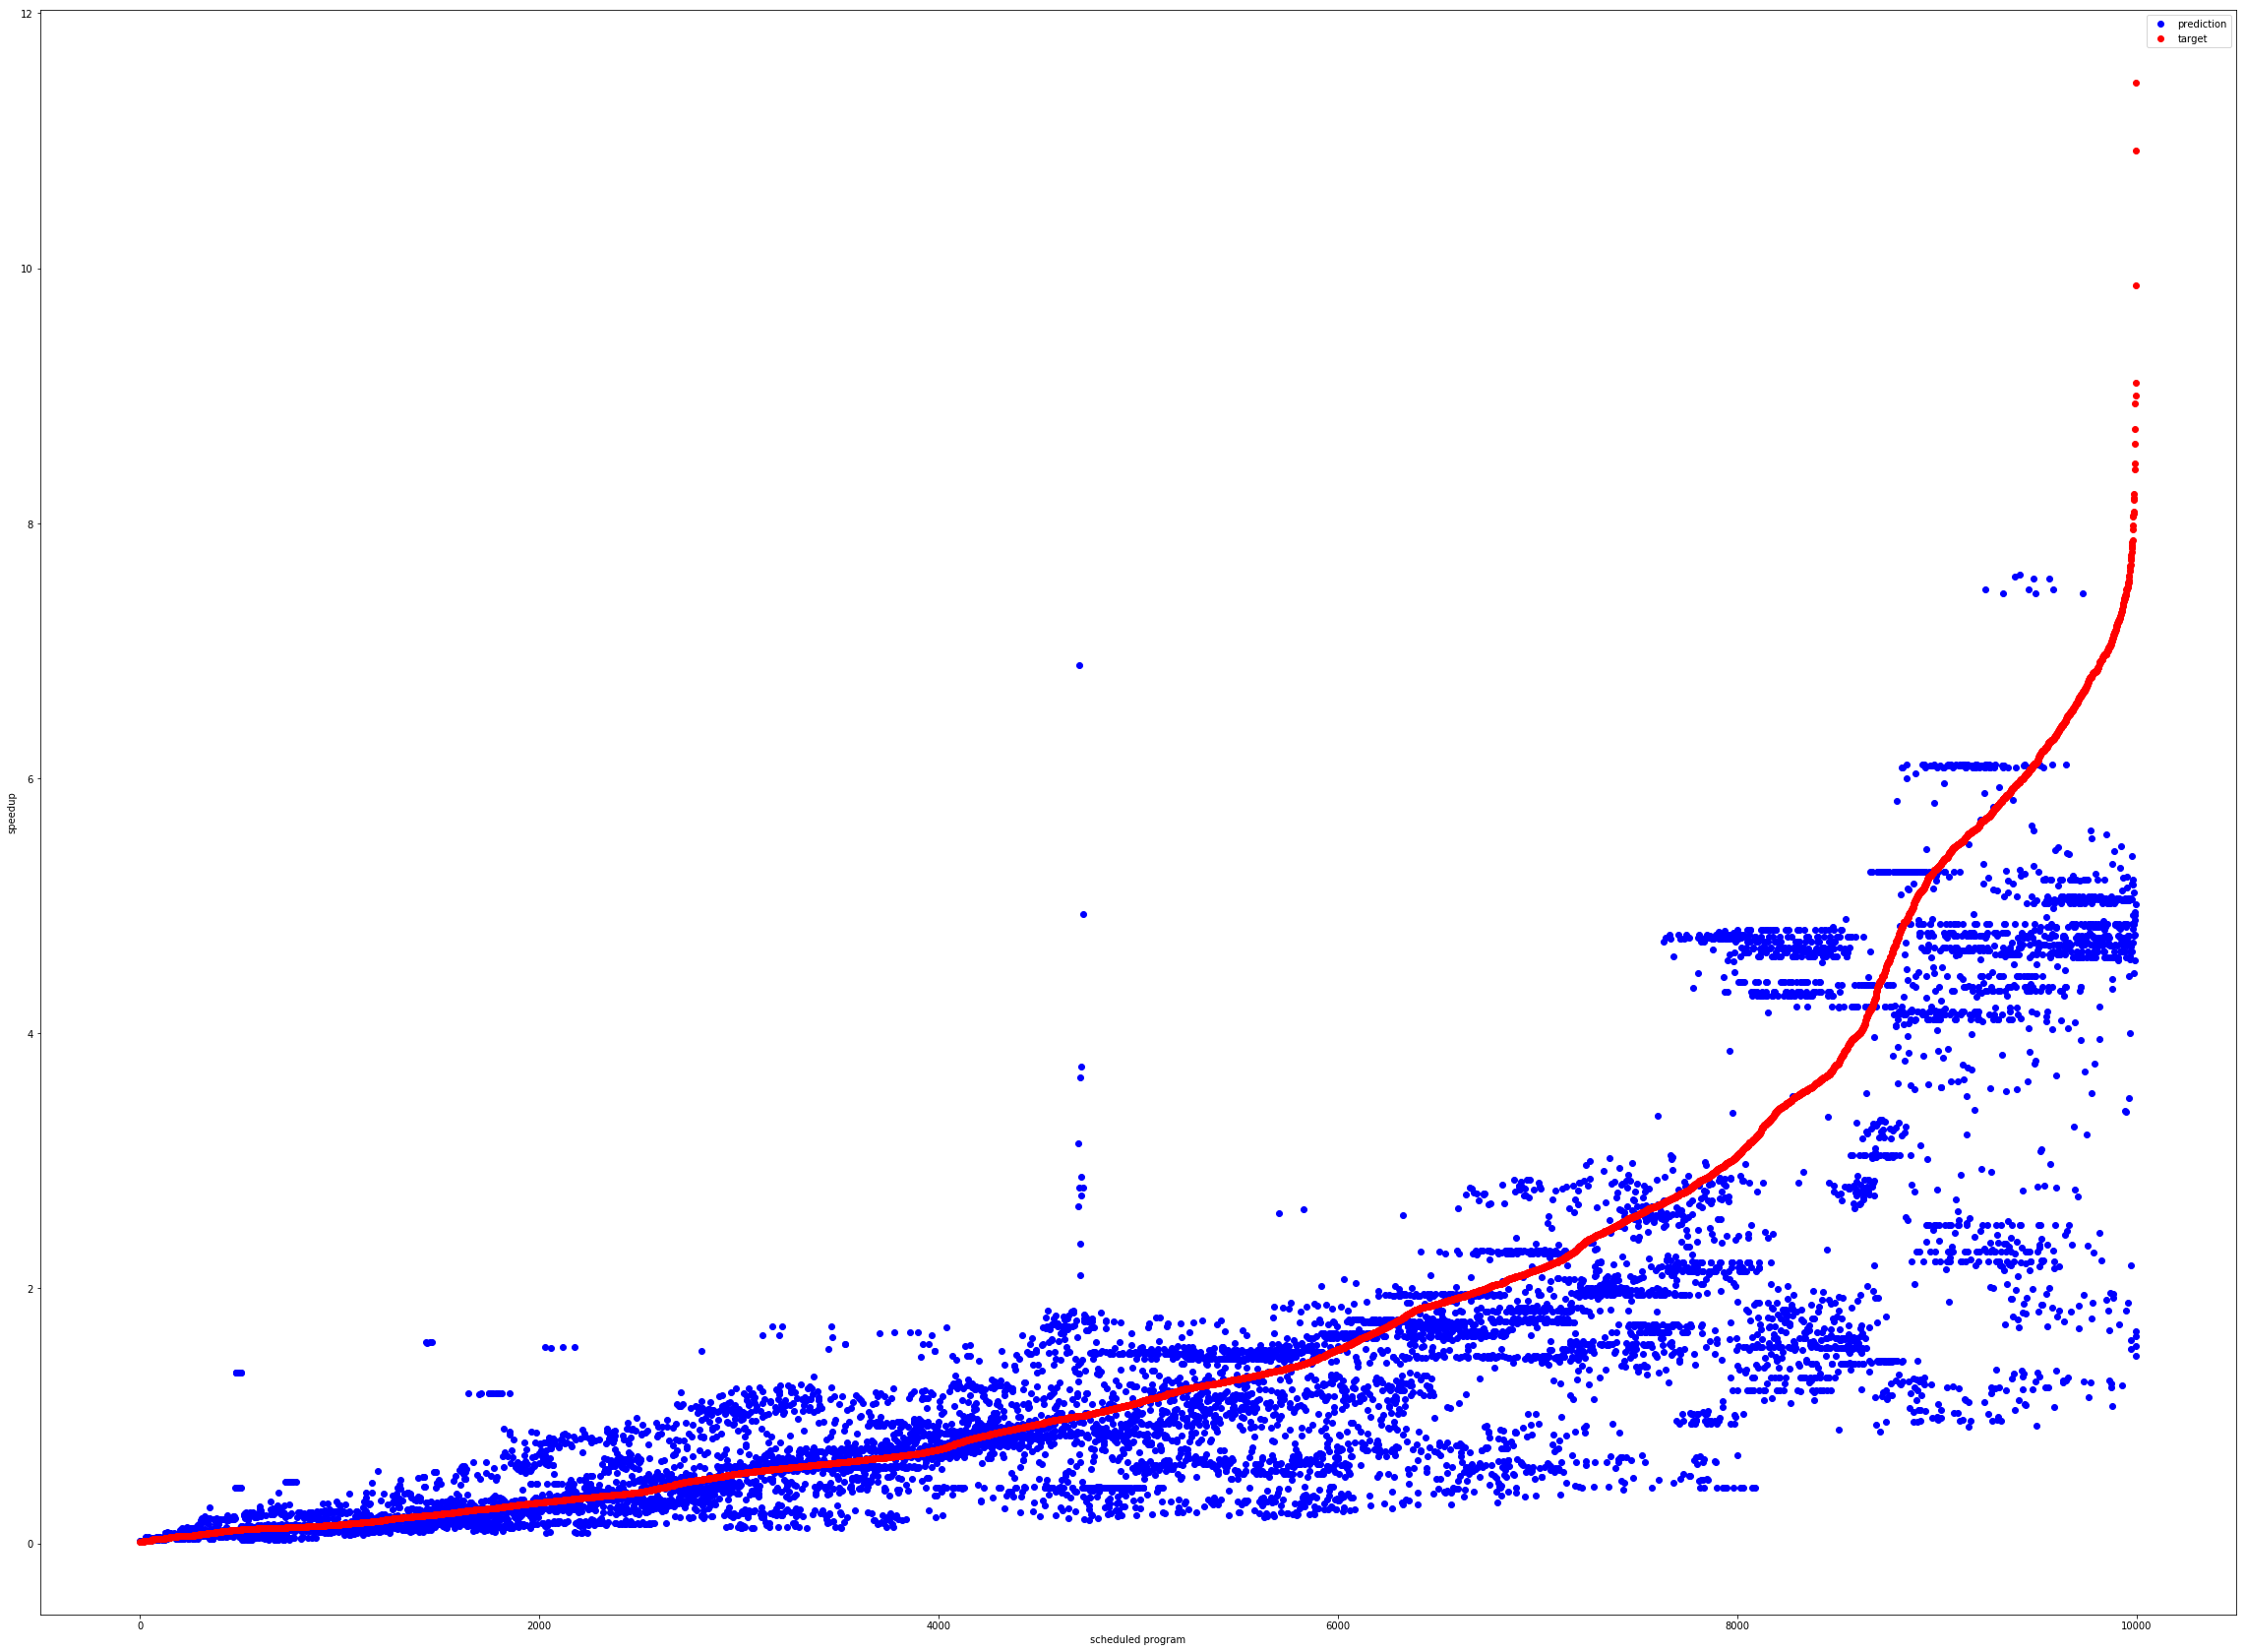

In [28]:
plt.plot('x', 'prediction', 'bo', data=df_)
plt.plot('x', 'target','ro', data=df_)

plt.xlabel('scheduled program')
plt.ylabel('speedup')
plt.legend()

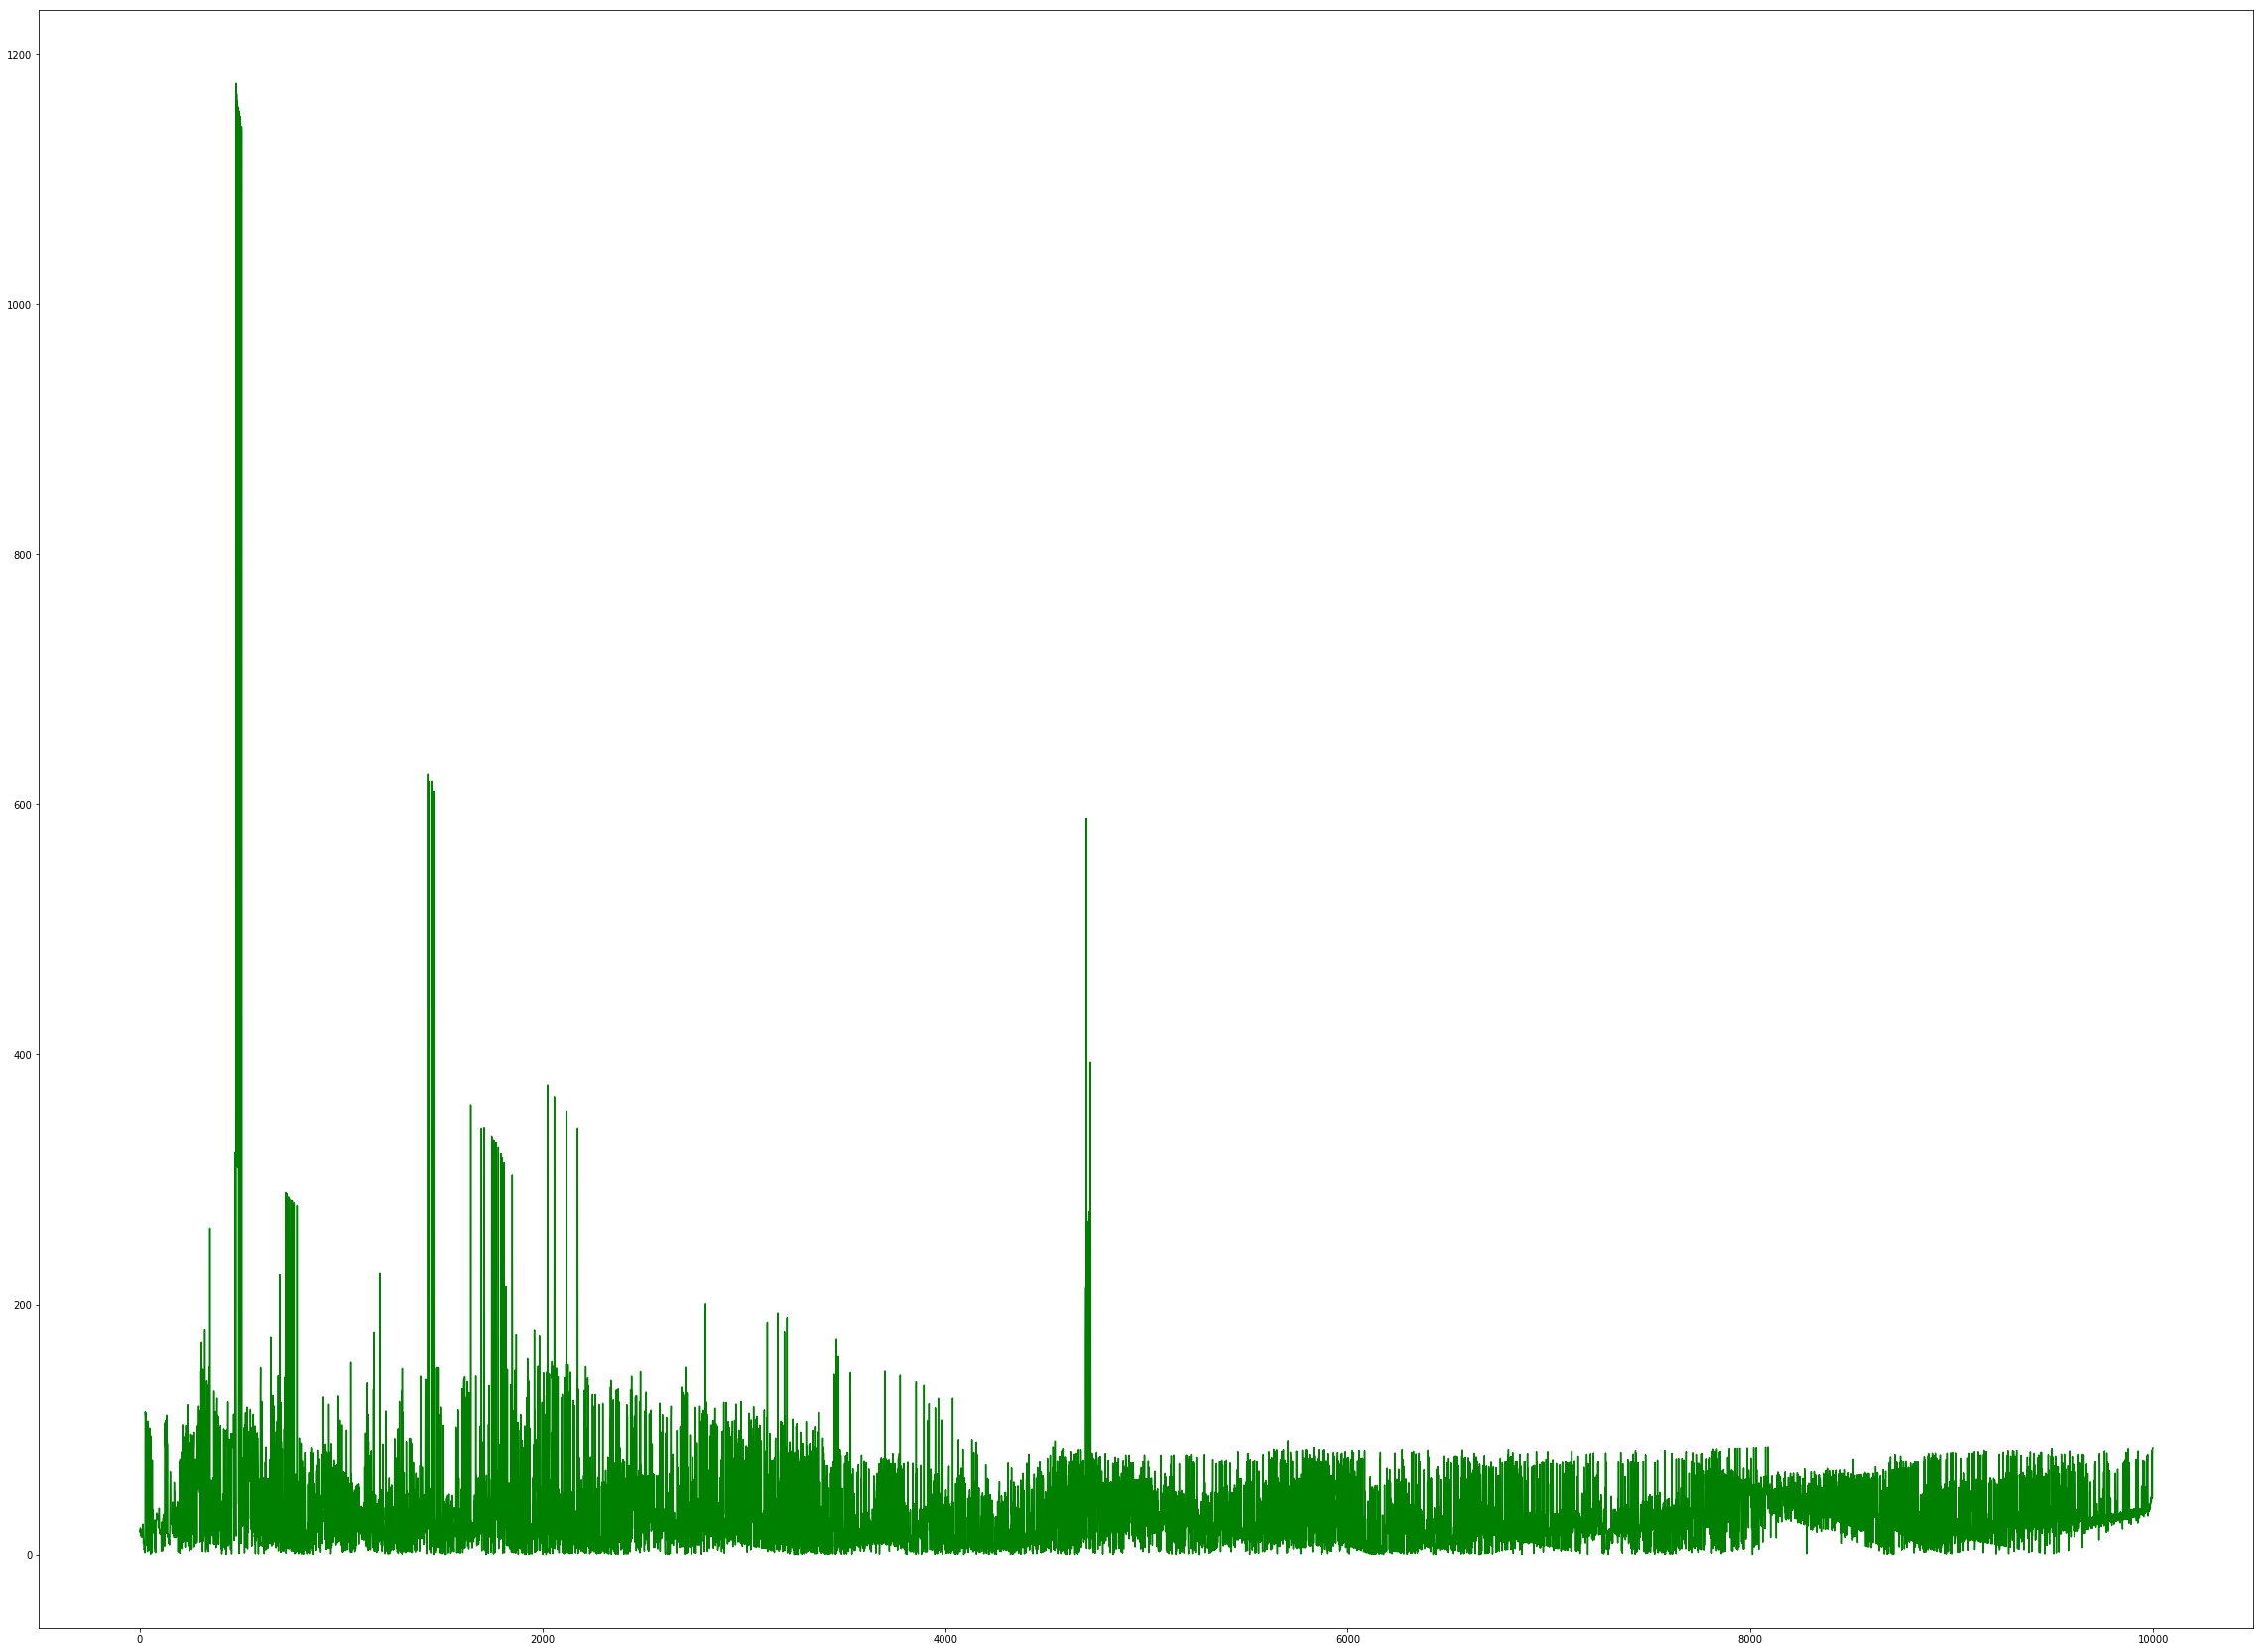

In [32]:
plt.plot('x', 'APE', 'g-', data=df_)